## Question Answering
In this exercise, you will experiment with one of NLP’s exciting tasks - Question Answering!

You will first evaluate a pre-trained model on Squad, a leading question-answering dataset, and evaluate its performance. Those with an approved access to GPUs in AWS or a different provider are encouraged to also fine-tune a base model on the Squad dataset.

We will use HuggingFace’s Transformers, the leading package for NLP tasks using transformers. Your code should roughly follow the code of [this guide](https://huggingface.co/docs/transformers/tasks/question_answering) and [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/question_answering.ipynb).

(**Important Note:** The guide writes considerable amount of code to handle the case of context longer than the max input sequence. For simplicity, in your code, you should remove from the datasets all contexts longer than
`max_length = 384`)


This exercise utilizes large models. While we only fine-tune existing models, the time required for fine-tuning could be still large so you are not expected to make many runs.


Install the transformers, datasets libraries

In [ ]:
! pip install datasets transformers==4.28.0

Import required libraries.
Make sure your version of Transformers is at least 4.11.0.

In [2]:
import transformers
import torch

print(transformers.__version__)

4.28.0


We will use the 🤗 [Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions load_dataset and load_metric.

For our example here, we'll use version 1.1 of Stanford's [SQUAD dataset](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/).

Load the Squad v1.1 dataset.

In [3]:
from datasets import load_dataset, load_metric

datasets = load_dataset("squad")

  0%|          | 0/2 [00:00<?, ?it/s]

### Getting to know the dataset

The datasets object itself is DatasetDict, which contains one key for the training, validation and test set.

In [4]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [5]:
datasets["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

Now, answer these questions:

What is the shortest context in the training dataset?


In [9]:
import pandas as pd
import numpy as np

train_df = pd.DataFrame(datasets["train"])
train_df['context_length'] = train_df['context'].apply(lambda x: len(x))
min_context_length = np.min(train_df['context_length'].values)
min_context_length

151

What is the longest answer in the dataset?

In [10]:
max_context_length = np.max(train_df['context_length'].values)
max_context_length

3706

Is there a question that appears multiple times? What is the most common question?

In [11]:
common_questions = train_df.groupby(['question']).size().sort_values(ascending=False)
common_questions.head(10)

question
Who won this season of Idol?                                                                                 6
Which Caribbean nation is in the top quartile of HDI (but missing IHDI)?                                     6
I couldn't could up with another question. But i need to fill this space because I can't submit the hit.     6
Who was a pop idol that started on American Idol?                                                            5
dd                                                                                                           4
What has caused a decrease in CD sales?                                                                      3
What is one reason that a homosexual would engage in heterosexual behavior?                                  3
What is pantheism?                                                                                           3
What is one of the features that have come to be considered as an important part of the Gothic style?  

### HuggingFace transformers’ tokenizers
As a preprocessing step, the HuggingFace code tokenizes input sequences using a Tokenizer. Read more about tokenizers here:
https://huggingface.co/docs/tokenizers/pipeline
https://huggingface.co/transformers/v3.0.2/preprocessing.html

For this question, use the BERT tokenizer. The tokenizer sometimes breaks words into smaller chunks, so the number of tokens can be larger than the number of words.

Using the first 1,000 context datapoints, print the 30 most common tokens by the tokenizer.


In [12]:
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

MAX_LENGTH = 1000
K_MOST_COMMON = 30

def tokenize_context(context):
  context_encoding = tokenizer(
      context,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_tensors='pt',
    )

  return context_encoding['input_ids']


train_context_encoding = train_df['context'].apply(lambda x: tokenize_context(x))
single_tensor = torch.cat(list(train_context_encoding.values)).flatten()
unique_elements, counts = torch.unique(single_tensor, sorted=True, return_counts=True)
most_frequent_elements = unique_elements[counts.argsort(descending=True)[:K_MOST_COMMON]]
most_frequent_tokens = [tokenizer.decode(input_id) for input_id in most_frequent_elements]

most_frequent_tokens

['[PAD]',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 'a',
 '"',
 '-',
 'The',
 'as',
 '##s',
 ')',
 '(',
 'is',
 'was',
 '[SEP]',
 '[CLS]',
 "'",
 'by',
 's',
 'for',
 'that',
 'with',
 'on',
 'from',
 'are',
 'In']

### Load a pretrained Question Answering model
In this section, you will use a model pretrained on the Squad dataset for question answering.

Choose a model you'd like to use.
You can see a list of available models here: https://huggingface.co/models?dataset=dataset:squad&sort=downloads


Load the model.

In [13]:
from transformers import pipeline

device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MODEL_NAME = 'distilbert-base-cased-distilled-squad'
question_answerer_model = pipeline("question-answering", model=MODEL_NAME, device=device)

In [14]:
def answer_question(context, question):
  result = question_answerer_model(question=question, context=context)
  return result


In [10]:
train_results = []

for sample in datasets['train']:
  result = answer_question(sample['context'], sample['question'])
  result['label_answer_text'] = sample['answers']['text'][0]
  result['label_answer_start'] = sample['answers']['answer_start'][0]
  result['context_length'] = len(sample['context'])
  train_results.append(result)


train_results = pd.DataFrame(train_results)
train_results

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,score,start,end,answer,label_answer_text,label_answer_start,context_length
0,0.995938,515,541,Saint Bernadette Soubirous,Saint Bernadette Soubirous,515,695
1,0.360485,188,213,a copper statue of Christ,a copper statue of Christ,188,695
2,0.231049,279,296,the Main Building,the Main Building,279,695
3,0.939583,381,420,a Marian place of prayer and reflection,a Marian place of prayer and reflection,381,695
4,0.371973,92,126,a golden statue of the Virgin Mary,a golden statue of the Virgin Mary,92,695
...,...,...,...,...,...,...,...
87594,0.978198,229,235,Oregon,Oregon,229,767
87595,0.991721,414,421,Rangoon,Rangoon,414,767
87596,0.571325,476,492,Minsk of Belarus,Minsk,476,767
87597,0.998435,199,203,1975,1975,199,767


### Pretrained Model Error Analysis
Here you will evaluate your model’s performance.

Write code to manually review a few errors of the model.


In [11]:
wrong_text_answer = train_results[train_results['label_answer_text'] != train_results['answer']]
wrong_text_answer

,score,start,end,answer,label_answer_text,label_answer_start,context_length
6,0.787036,441,453,twice a year,twice,441,1405
17,0.717567,130,148,College of Science,the College of Science,126,724
19,0.661855,159,164,1870s,the 1870s,155,724
27,0.664454,92,101,1854–1855,1854,92,1427
41,0.499795,217,229,top 10 to 15,the top 10 to 15 in the nation,213,962
...,...,...,...,...,...,...,...
87568,0.696473,182,187,Ajima,worship of Ajima,171,527
87572,0.751389,633,637,4.2%,4.2,633,1138
87574,0.855092,46,66,Tribhuwan University,Tribhuwan,46,522
87586,0.434246,500,510,BP Highway,BP,500,584


In [12]:
def print_errors(errors, train_dataset, number_of_erros=5):

  errors_to_show = errors.iloc[:number_of_erros]

  for index, row in errors_to_show.iterrows():
    context = train_dataset[index]['context']
    question = train_dataset[index]['question']
    predicted_answer = row['answer']
    label_answer = row['label_answer_text']

    print(f'Context: \n{context}\n')
    print(f'Question: \n{question}\n')
    print(f'Model Answer: \n{predicted_answer}\n')
    print(f'Label Answer: \n{label_answer}\n')
    print("\n\n")

In [13]:
def get_error_type(label_answer, pridected_answer):

  if label_answer.find(pridected_answer) >=0:
    return "Real answer is part of predicted answer"
  elif pridected_answer.find(label_answer) >=0:
    return "Predicted answer is part of label answer"
  else:
    return "Real answer and predicted answer are not contained within each other"


wrong_text_answer['error_type'] = wrong_text_answer.apply(lambda x: get_error_type(x['label_answer_text'].lower(), x['answer'].lower()), axis=1)

<ipython-input-13-144edb0ad720>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_text_answer['error_type'] = wrong_text_answer.apply(lambda x: get_error_type(x['label_answer_text'].lower(), x['answer'].lower()), axis=1)


## Error type 1- Real answer is part of predicted answer


In [14]:
type_1_errors = wrong_text_answer[wrong_text_answer['error_type'] == "Real answer is part of predicted answer"]
type_1_errors

,score,start,end,answer,label_answer_text,label_answer_start,context_length,error_type
17,0.717567,130,148,College of Science,the College of Science,126,724,Real answer is part of predicted answer
19,0.661855,159,164,1870s,the 1870s,155,724,Real answer is part of predicted answer
41,0.499795,217,229,top 10 to 15,the top 10 to 15 in the nation,213,962,Real answer is part of predicted answer
43,0.493318,628,631,750,more than 750 miles,618,962,Real answer is part of predicted answer
49,0.766645,0,21,Father Joseph Carrier,"Father Joseph Carrier, C.S.C.",0,1033,Real answer is part of predicted answer
...,...,...,...,...,...,...,...,...
87311,0.686367,269,272,rot,leaving the rest to rot,249,532,Real answer is part of predicted answer
87369,0.001352,100,133,"Lalitpur, Bhaktapur, and Kirtipur","Kantipur, Lalitpur, Bhaktapur, and Kirtipur",90,1285,Real answer is part of predicted answer
87392,0.437387,438,455,humid subtropical,humid subtropical climate,438,758,Real answer is part of predicted answer
87415,0.346933,487,504,Maoist insurgency,end of the Maoist insurgency,476,894,Real answer is part of predicted answer


In [15]:
print_errors(type_1_errors, datasets['train'])

Context: 
The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering, includes five departments of study – aerospace and mechanical engineering, chemical and biomolecular engineering, civil engineering and geological sciences, computer science and engineering, and electrical engineering – with eight B.S. degrees offered. Additionally, the college offers five-year dual degree programs with the Colleges of Arts and Letters and of Business awarding additional B.A. and Master of Business Administration (MBA) degrees, respectively.

Question: 
Before the creation of the College of Engineering similar studies were carried out at which Notre Dame college?

Model Answer: 
College of Science

Label Answer: 
the College of Science




Context: 
The College of Engineering was established in 1920, h

## Error type 2- Predicted answer is part of label answer


In [16]:
type_2_errors = wrong_text_answer[wrong_text_answer['error_type'] == "Predicted answer is part of label answer"]
type_2_errors

,score,start,end,answer,label_answer_text,label_answer_start,context_length,error_type
6,0.787036,441,453,twice a year,twice,441,1405,Predicted answer is part of label answer
27,0.664454,92,101,1854–1855,1854,92,1427,Predicted answer is part of label answer
67,0.606606,0,22,The Review of Politics,Review of Politics,4,584,Predicted answer is part of label answer
122,0.591312,432,442,389 to 950,950,439,501,Predicted answer is part of label answer
129,0.781338,314,326,1240 to 1360,1240,314,772,Predicted answer is part of label answer
...,...,...,...,...,...,...,...,...
87563,0.558924,196,204,over 108,108,201,552,Predicted answer is part of label answer
87572,0.751389,633,637,4.2%,4.2,633,1138,Predicted answer is part of label answer
87574,0.855092,46,66,Tribhuwan University,Tribhuwan,46,522,Predicted answer is part of label answer
87586,0.434246,500,510,BP Highway,BP,500,584,Predicted answer is part of label answer


In [17]:
print_errors(type_2_errors, datasets['train'])

Context: 
As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page journal in September 1876, the Scholastic magazine is issued twice monthly and claims to be the oldest continuous collegiate publication in the United States. The other magazine, The Juggler, is released twice a year and focuses on student literature and artwork. The Dome yearbook is published annually. The newspapers have varying publication interests, with The Observer published daily and mainly reporting university and other news, and staffed by students from both Notre Dame and Saint Mary's College. Unlike Scholastic and The Dome, The Observer is an independent publication and does not have a faculty advisor or any editorial oversight from the University. In 1987, when some students believed that The Observer began to show a conservative b

## Error type 3- "Real answer and predicted answer are not contained within each other


In [18]:
type_3_errors = wrong_text_answer[wrong_text_answer['error_type'] == "Real answer and predicted answer are not contained within each other"]
type_3_errors

,score,start,end,answer,label_answer_text,label_answer_start,context_length,error_type
120,0.294929,276,288,$350 million,$9 million,262,501,Real answer and predicted answer are not conta...
294,0.397573,757,758,4,Beyoncé,180,1016,Real answer and predicted answer are not conta...
366,0.427677,190,199,the split,split with Luckett and Rober,194,832,Real answer and predicted answer are not conta...
426,0.739503,574,579,three,five,346,686,Real answer and predicted answer are not conta...
493,0.398228,52,64,January 2010,During the break,143,427,Real answer and predicted answer are not conta...
...,...,...,...,...,...,...,...,...
87269,0.253005,400,438,primarily for commercial sale or sport,to endangerment or extinction,475,505,Real answer and predicted answer are not conta...
87276,0.267078,451,541,purchase or lease of wetland habitat for prote...,the purchase or lease of wetland habitat,447,733,Real answer and predicted answer are not conta...
87391,0.263564,740,747,10.1 °C,50.2,749,758,Real answer and predicted answer are not conta...
87426,0.129999,57,71,Central Sector,City Core,112,1086,Real answer and predicted answer are not conta...


In [19]:
print_errors(type_3_errors, datasets['train'])

Context: 
The Rev. Theodore Hesburgh, C.S.C., (1917–2015) served as president for 35 years (1952–87) of dramatic transformations. In that time the annual operating budget rose by a factor of 18 from $9.7 million to $176.6 million, and the endowment by a factor of 40 from $9 million to $350 million, and research funding by a factor of 20 from $735,000 to $15 million. Enrollment nearly doubled from 4,979 to 9,600, faculty more than doubled 389 to 950, and degrees awarded annually doubled from 1,212 to 2,500.

Question: 
What was the size of the Notre Dame endowment when Theodore Hesburgh became president?

Model Answer: 
$350 million

Label Answer: 
$9 million




Context: 
Following the disbandment of Destiny's Child in June 2005, she released her second solo album, B'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006), and starring roles in The Pink Panther (

Do you see a pattern there? Is there any hypothesis you form for cases where the model fails?

For the error analysis i find "errors" by using Exact match metric.
Any sample that the predicted answer doesn't match the answer exactly is labeled has error.

I can see few patterns:

*  Around 60% of the errors, are type 1 errors (Real answer is part of predicted answer).

I can see that the model answer in many cases are more fully than the real answer, it's can be more precise answer like:
  1.   predicted answer: twice a year
  2.   label answer: twice

or just few words that doesn't change the answer like stop words.
Is difficult to say that this errors are really errors because the right answer is contained in the predicted answer.

*    Around 30% of the errors, are type 2 errors (Predicted answer is part of real answer).

Again in many cases the difference between the answers are stop words, or more fully answer.
Also in this cases it's hard to say the predicted answer is wrong, because it's contains the relevant information for the answer.


*   Around 10% of the errors are type 3 errors (Real answer and predicted answer are not contained within each other).

This type contains more realistic errors, when the predicted answer is truly wrong. In many of this cases the answer is an year, numeric value .
In addtition also in this errors i find "errors" that are not truly errors, for example model predicted female but the real answer is women.


Because most of the errors are not real "errors" but just not Exact match, i will use metric that is more rubost to changes between the predicted  answer and the label answer, as long as the semantics are the same in both answers.

Write code that runs inference and outputs the predicted answer to a context and question texts typed by the user. We recommend that you use ipywidgets for interactivity:
https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html

Use the award-winning GUI you’ve just created, to try to manually poke holes in the model. Try to characterize the cases your model mishandles.


In [20]:
def run_question(button):

  context = widget_context.value
  question = widget_question.value
  answer = answer_question(context, question)
  print(f'Context: {context}')
  print(f'Question: {question}')

  answer_widget.value = str(result['label_answer_text'])
  with answer_widget:
    clear_output(wait=True)
    answer_widget.append_display_data( answer_widget.value)

In [21]:
from IPython.display import display, clear_output
import ipywidgets as widgets

widget_context = widgets.Text(description='Enter context', placeholder='context')
widget_question = widgets.Text(description='Enter question', placeholder='question')

button_widget = widgets.Button(
    description='Get answer',
    disabled=False,
    button_style='',
    icon='check'
)

button_widget.on_click(run_question)
answer_widget = widgets.Output()

display(widget_context, widget_question, button_widget, answer_widget)

Text(value='', description='Enter context', placeholder='context')

Text(value='', description='Enter question', placeholder='question')

Button(description='Get answer', icon='check', style=ButtonStyle())

Output()

Context: The president of the USA is Joe Biden
Question:  Who is the president of USA?


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Context: The president of the USA is Joe Biden

Question: Who is the president of USA?

prediction Kathmandu Metropolitan City

When the context is very short (few words) the preformance of the model are very poor.


Next, evaluate your model’s performance for different lengths of input text and of answer length.

In [22]:
train_results['correct_answer'] = train_results.apply(lambda x: True if x['answer'] == x['label_answer_text'] else False, axis=1)
train_results['group_length'] = train_results['context_length'].apply(lambda x: int(x / 10))
train_results

,score,start,end,answer,label_answer_text,label_answer_start,context_length,correct_answer,group_length
0,0.995938,515,541,Saint Bernadette Soubirous,Saint Bernadette Soubirous,515,695,True,69
1,0.360485,188,213,a copper statue of Christ,a copper statue of Christ,188,695,True,69
2,0.231049,279,296,the Main Building,the Main Building,279,695,True,69
3,0.939583,381,420,a Marian place of prayer and reflection,a Marian place of prayer and reflection,381,695,True,69
4,0.371973,92,126,a golden statue of the Virgin Mary,a golden statue of the Virgin Mary,92,695,True,69
...,...,...,...,...,...,...,...,...,...
87594,0.978198,229,235,Oregon,Oregon,229,767,True,76
87595,0.991721,414,421,Rangoon,Rangoon,414,767,True,76
87596,0.571325,476,492,Minsk of Belarus,Minsk,476,767,False,76
87597,0.998435,199,203,1975,1975,199,767,True,76


In [23]:
group_by_length = pd.DataFrame(train_results.groupby(['group_length', 'correct_answer']).size() / train_results.groupby(['group_length']).size())
group_by_length.reset_index(inplace=True)
group_by_length

,group_length,correct_answer,0
0,15,False,0.200000
1,15,True,0.800000
2,16,False,0.242604
3,16,True,0.757396
4,17,False,0.184932
...,...,...,...
445,335,True,0.600000
446,338,False,0.800000
447,338,True,0.200000
448,370,False,0.600000


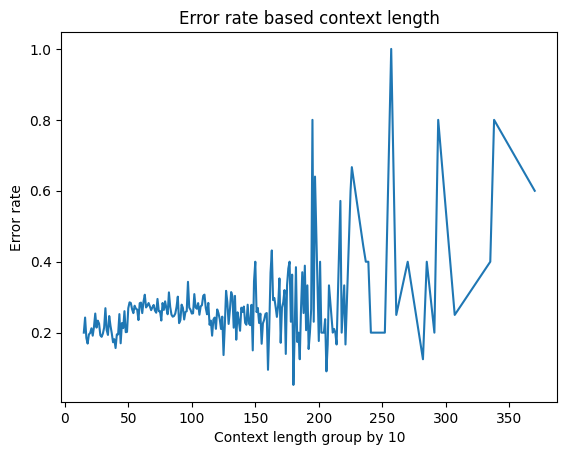

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x="group_length", y=0,
                data=group_by_length[group_by_length['correct_answer'] == False])

plt.xlabel("Context length group by 10")
plt.ylabel("Error rate")
plt.title("Error rate based context length");

We can see that as the context length increase the error rate increased too

BONUS: Can you think of other axes that would be interesting to use to evaluate your model?

We can see that for errors type 3, the score distribution is different compare to the other errros. In type 3 errors the score are more often lower, with means the model is less confident in the answer it's returned.

### [Advanced] Fine-tune a Model
Here, you will fine-tune a base model to the Squad dataset, and evaluate its performance.

What metric do you find suited? Why?


As we see from the error analysis, exact match can cause an error in the model performance estimation, because many of the "errors" contains the real answer.

Because of this we need to use metric that take into account also part of the answer.

We can use one of the following metrics:

  1.  Jaccard similarity between tokens
  2.  Levenshtein distance netween prediction and label
  3.  Cosine similarity between prediction and label
  4.  F1

When the label and the prediction as exact match the similarity will be 1.
When there is no intersection the simialrity will be 0.
The problem with this metric is that is preferred long answers, for example if the ansert is "answer" and the prediction is "the answer" the simialrity will bw 0.5, and as the length of the answer is increased the impact of this mistakes will be lower. But because it's fast to calculate and easy to understand i will use this metric.

Train the model to fine-tune on the dataset.

In [15]:
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizer
from transformers import default_data_collator

data_collator = default_data_collator
model_name = "distilbert-base-cased-distilled-squad"
model = DistilBertForQuestionAnswering.from_pretrained(model_name)
tokenizer = tokenizer = AutoTokenizer.from_pretrained(model_name)

In [16]:
DOC_STRIDE = 128
MAX_LENGTH = 384
PAD_ON_RIGHT = tokenizer.padding_side == "right"



def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if PAD_ON_RIGHT else "context"],
        examples["context" if PAD_ON_RIGHT else "question"],
        truncation="only_second" if PAD_ON_RIGHT else "only_first",
        max_length=MAX_LENGTH,
        stride=DOC_STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if PAD_ON_RIGHT else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if PAD_ON_RIGHT else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples



In [17]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

Write below your train and validation loss.

In [18]:
from transformers import Trainer, TrainingArguments
import torch

torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir='results',
    save_total_limit=2,
    load_best_model_at_end=True,
    num_train_epochs=2,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=2e-5,
    evaluation_strategy='steps',
    logging_steps=200,
    eval_steps=200,
    save_steps=200,
    warmup_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
200,0.557500,1.123484
400,0.562600,1.123854
600,0.576700,1.124583
800,0.516500,1.164558
1000,0.485000,1.177696
1200,0.477700,1.181352


TrainOutput(global_step=1388, training_loss=0.5224692759665014, metrics={'train_runtime': 1517.7454, 'train_samples_per_second': 116.922, 'train_steps_per_second': 0.915, 'total_flos': 1.7389078369108992e+16, 'train_loss': 0.5224692759665014, 'epoch': 2.0})

In [19]:
predictions  = trainer.predict(tokenized_datasets["validation"])

In [37]:
token_ids = torch.tensor(tokenized_datasets["validation"]["input_ids"])
start_positions = tokenized_datasets["validation"]["start_positions"]
end_positions = tokenized_datasets["validation"]["end_positions"]

# Get predicted start and end indices
predicted_starts = np.argmax(predictions.predictions[0], axis=1)
predicted_ends = np.argmax(predictions.predictions[1], axis=1)

# Decode predicted answers
predicted_answers = []
for token_id, start, end in zip(token_ids, predicted_starts, predicted_ends):
    prediction_answer = tokenizer.decode(token_id.squeeze()[start:end+1])
    predicted_answers.append(prediction_answer.lower())


# Decode label answers
label_answers = []
for token_id, start, end in zip(token_ids, start_positions, end_positions):
    label_answer = tokenizer.decode(token_id.squeeze()[start:end+1])
    label_answers.append({"text": [label_answer.lower()], "answer_start": [start]})


In [39]:
from datasets import load_dataset, load_metric

metric = load_metric("squad_v2")

formatted_predictions = [{"id": index, "prediction_text": answer, "no_answer_probability": 0.0} for index, answer in enumerate(predicted_answers)]
formatted_answers = [{"id": index, "answers": answer} for index, answer in enumerate(label_answers)]

metric.compute(predictions=formatted_predictions, references=formatted_answers)

{'exact': 64.46128257253743,
 'f1': 78.6148089489034,
 'total': 10822,
 'HasAns_exact': 64.46128257253743,
 'HasAns_f1': 78.6148089489034,
 'HasAns_total': 10822,
 'best_exact': 64.46128257253743,
 'best_exact_thresh': 0.0,
 'best_f1': 78.6148089489034,
 'best_f1_thresh': 0.0}

## Recommended Resources
For an open discussion on Question Answering related topics, you are very encouraged to watch this workshop: https://www.youtube.com/watch?v=Ihgk8kGLpIE

This screencast uses T5 on a different Q&A dataset: https://www.youtube.com/watch?v=_l2wJb3QPdk



That's it - good luck!